# Error Estimation

In [7]:
import numpy as n
import matplotlib.pyplot as plt
import capo
n.random.seed(100) # for reproducibility

# Make fake data array
times = 1000
data = capo.oqe.noise(size=times)

# Make fake FRF data 
N = 10 # number of samples to average together for FRF data
data_frf = n.convolve(data, n.ones((N,))/N, mode='valid')

# Plot data
#plt.plot(data.real,'k-');plt.plot(data_frf.real,'b-');plt.show()

# Under-estimating errors of FRF data

In [8]:
# Traditional bootstrapping
Nboot = 100
ans = []
ans_frf = []
for i in range(Nboot):
    samples = n.random.choice(times, times, replace=True)
    draws = data[samples]
    samples_frf = n.random.choice(len(data_frf), len(data_frf), replace=True)
    draws_frf = data_frf[samples_frf]
    ans.append(n.mean(draws))
    ans_frf.append(n.mean(draws_frf))
print "Error:", n.std(ans)
print "FRF Error:", n.std(ans_frf)
print "Theoretical:", 1/n.sqrt(times)

Error: 0.0334258332769
FRF Error: 0.00993112805073
Theoretical: 0.0316227766017


Mean of data =  (-0.011859706193+0.0062464108603j)
Std of data =  1.02633218346


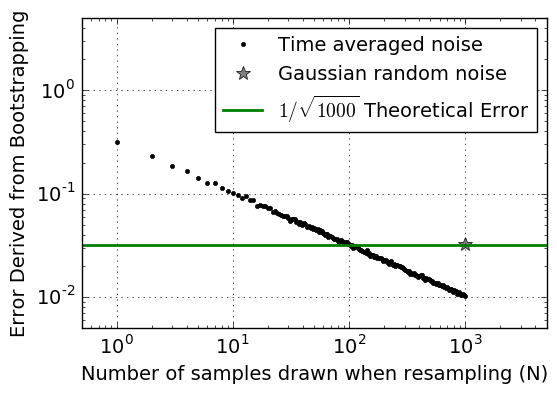

In [9]:
# Loop over number of samples drawn
N = 10 # number of samples to average together for FRF data
print 'Mean of data = ', n.mean(data)
print 'Std of data = ', n.std(data)
data_frf = n.convolve(data, n.ones((N,))/N, mode='valid')
#num_samp = n.arange(1,len(data_frf),5) # number of samples to draw when random sampling
num_samp = n.unique(n.array(n.logspace(0,n.log10(len(data_frf)),300),dtype='int')) # equal spacing in log-space (but gets rid of repeated integer values)
Nboot = 500
for NN,num in enumerate(num_samp): # loop for FRF data
    ans_frf = []
    for i in range(Nboot):
        samples_frf = n.random.choice(len(data_frf), num, replace=True)
        draws_frf = data_frf[samples_frf]
        ans_frf.append(n.mean(draws_frf))
    plt.loglog(num, n.std(ans_frf), 'k.', linestyle='None', label='Time averaged noise' if NN==0 else '')
ans = []
for i in range(Nboot): # loop for one data point for original data
    samples = n.random.choice(len(data), len(data), replace=True)
    draws = data[samples]
    ans.append(n.mean(draws))
plt.loglog(len(data), n.std(ans), color='0.5', marker='*', ms=10, linestyle='None', label='Gaussian random noise')
plt.axhline(y=1/n.sqrt(times), color='g', linestyle='-', label='$1/\sqrt{1000}$ Theoretical Error', linewidth=2)
plt.xlabel('Number of samples drawn when resampling (N)', fontsize=14)
plt.ylabel('Error Derived from Bootstrapping', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.legend(prop={'size':14}, numpoints=1,loc='best')
plt.xlim(0.5e0,0.5e4)
plt.ylim(0.5e-2,5)
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_error1.pdf',bbox_inches='tight')
plt.show()

# Over-estimating errors when bootstrapping

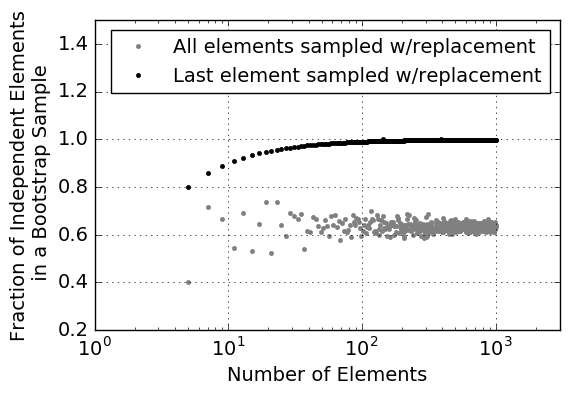

In [5]:
import numpy as n
import matplotlib.pyplot as plt

# GENERAL EXAMPLE: Loop over number of samples in a dataset
N = 1000
Nstart = 5
for NN,Nbls in enumerate(n.arange(Nstart,N,2)):
    bls = n.arange(1,Nbls+1,1)
    sample_old = n.random.choice(len(bls),size=len(bls)) #bls[[n.random.choice(bl) for bl in bls]] # sample w/replacement
    sample_new = n.concatenate((bls[:-1],[bls[n.random.choice(n.arange(0,len(bls)))]])) # only last sample is random
    unique_old = len(n.unique(sample_old))/float(len(bls))
    unique_new = len(n.unique(sample_new))/float(len(bls))
    plt.semilogx(Nbls, unique_old, color='0.5', marker='.', linestyle='None', label='All elements sampled w/replacement' if NN==0 else '')
    plt.semilogx(Nbls, unique_new, color='k', marker='.', linestyle='None', label='Last element sampled w/replacement' if NN==0 else '')
plt.ylim(0,1.5)
plt.xlabel('Number of Elements', fontsize=14)
plt.ylabel('Fraction of Independent Elements\n in a Bootstrap Sample', fontsize=14) 
plt.legend(numpoints=1, prop={'size':14}, loc='best')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.xlim(1e0,0.3e4)
plt.ylim(0.2,1.5)
plt.savefig('/home/cacheng/capo/ctc/methods_paper_images/toy_error2.pdf',bbox_inches='tight')
plt.show()

# Noise Sim: comparing error of noise in sampled vs. non-sampled case

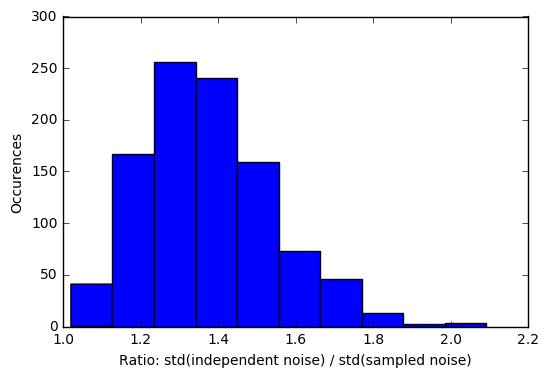

In [102]:
# Toy model: noise
#   - effect of having repeated baselines when sampling w/replacement

times = 100 # length of data
nbls = 10 # number of baselines
scale = 13 # std of noise
nsims = 1000

ratios = []
for i in range(nsims):
    data = {}
    noises = []
    for bl in range(nbls): # loop through baselines and save noise for each
        noise = n.random.normal(size=times,scale=scale) # random noise 
        noises.append(noise) # save in big array
        data[bl] = noise # save in dictionary
    noises = n.mean(noises,axis=0) # mean noises (for this case each baseline noise is independent!!)
    #print 'Std of noise on all baselines =',n.std(noises) 

    # Sample with replacement
    bls_sample = n.random.choice(n.arange(nbls),nbls,replace=True) 
    #print '\nUnique bls in sample =',len(n.unique(bls_sample)) # there are less unique baselines

    samples = []
    for bl in bls_sample: # loop through sampled baselines and save noise per baseline
        samples.append(data[bl]) 
    samples = n.mean(samples,axis=0) # mean again (but this time not all baselines are independent!!)
    #print 'Std of random sampled noise =',n.std(samples)
    #print '\nRatio =',n.std(samples)/n.std(noises) # here is my missing factor!
    ratio = n.std(samples)/n.std(noises)
    ratios.append(ratio)

# Plot
p.hist(ratios)
p.ylabel('Occurences')
p.xlabel('Ratio: std(sampled noise) / std(independent noise)')
p.show()

# Noise Sim: simulating baseline grouping and sampling w/replacement

This reproduces the discrepancy seen in PAPER-64 data (errors too big for scatter in points, by a factor of ~1.5).

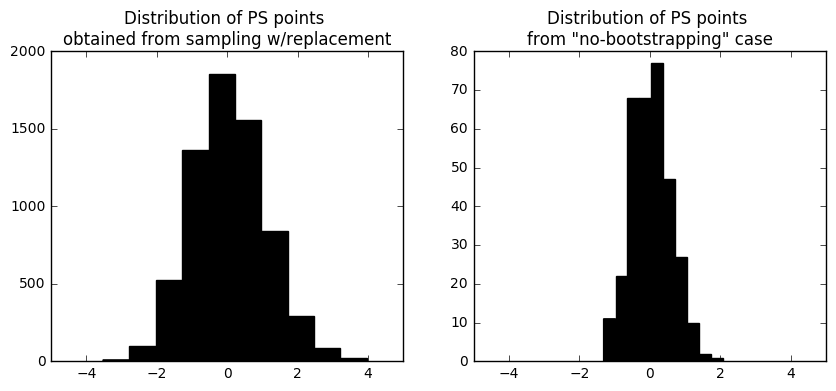

Standard deviation of PS points = 0.555905381856
Average errors = 0.843093374819
Ratio = 1.51661308262


In [126]:
import numpy as n
import pylab as p

# More realistic toy model for baseline bootstrapping

#n.random.seed(0) # for reproducibility

times = 100 # length of data
nbls = 50 # number of baselines
scale = 13 # std of noise
ngps = 5 # number of baseline groups
nboots = 20 # number of bootstraps
nks = 333 # number of k's (or "simulations")

def cross_multiply(data,bls):
    """
    Cross-multiplies unique baseline pairs.
    Averages data over time and cross-multiplications.
    Returns PS value.
    """
    crosses = []
    for bl1 in bls:
        for bl2 in bls[bl1:]:
                if bl1 != bl2:
                    cross = n.mean(data[bl1]*data[bl2]) # mean over 'time'
                    crosses.append(cross)
    return n.mean(crosses) # mean over cross-multiplications

def sum_data(data,gps):
    """
    Computes the average of data for all baselines within a group.
    Returns new data dictionary (indexed by group number) and group number indices.
    """
    data_gp = {}
    bls_gp = n.arange(len(gps))
    for gg,gp in enumerate(gps):
        data_sum = []
        for bl in gp: 
            data_sum.append(data[bl])
        data_gp[gg] = n.average(data_sum,axis=0)
    return data_gp,bls_gp

#---------------------------------------------

pts = [] # will contain PS points (size: nks)
errs = [] # will contain PS errors (size: nks)
pts_samp = [] # will contain PS points used to compute errs (from sampling w/replacement) - used for plotting only

for k in range(nks): # loop over k's (or number of "simulations")
    
    # Make noise per baseline
    data = {}
    bls = n.arange(nbls)
    for bl in bls:
        data[bl] = n.random.normal(size=times,scale=scale) # random noise 
    
    # Form baseline groups
    gps = [bls[i::ngps] for i in range(ngps)]

    # Bootstrap
    boot_data = []
    for boot in range(nboots): # loop over bootstraps
        gps_samp = [[gp[n.random.choice(n.arange(0,len(gp)))] for bl in gp] for gp in gps] # random sample w/replacement
        data_gp, bls_gp = sum_data(data,gps_samp) # average data together per group
        PS_pt = cross_multiply(data_gp,bls_gp) # compute PS value obtained from all cross-multiplications
        pts_samp.append(PS_pt)
        boot_data.append(PS_pt)
    err = n.std(boot_data) # error is std over bootstraps
    errs.append(err) # save error 
    
    # Compute PS for no-bootstrapping case
    data_gp_noboot, bls_gp_noboot = sum_data(data,gps) # average data together per (non-sampled w/replacement) group
    PS_pt = cross_multiply(data_gp_noboot,bls_gp_noboot) # compute PS value obtained from all cross-multiplications
    pts.append(PS_pt)
    
# Plot
p.figure(figsize=(10,4))
p.subplot(121)
p.hist(pts_samp,color='k')
p.xlim(-5,5)
p.title('Distribution of PS points \nobtained from sampling w/replacement')
p.subplot(122)
p.hist(pts,color='k')
p.xlim(-5,5)
p.title('Distribution of PS points \nfrom "no-bootstrapping" case')
p.show()

# Print some stuff
print 'Standard deviation of PS points =',n.std(pts)
print 'Average errors =',n.mean(errs)
print 'Ratio =',n.mean(errs)/n.std(pts)

# Noise Sim: simulating baseline sampling w/replacement (no groups)

This reproduces the same problem as above, but is simpler coding wise (no baseline groups).

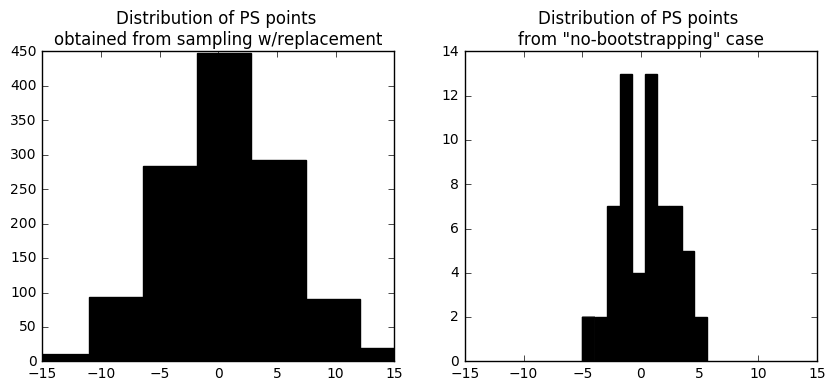

Standard deviation of PS points = 2.38069401866
Average errors = 4.24002646699
Ratio = 1.78100437677


In [129]:
import numpy as n
import pylab as p

# More realistic toy model for baseline bootstrapping (NO GROUPS)

n.random.seed(7) # for reproducibility

times = 100 # length of data
nbls = 10 # number of baselines
scale = 13 # std of noise
nboots = 20 # number of bootstraps
nks = 62 # number of k's (or "simulations")

def cross_multiply(data,bls):
    """
    Cross-multiplies unique baseline pairs.
    Averages data over time and cross-multiplications.
    Returns PS value.
    """
    crosses = []
    for bl1 in bls:
        for bl2 in bls[bl1:]:
                if bl1 != bl2:
                    cross = n.mean(data[bl1]*data[bl2]) # mean over 'time'
                    crosses.append(cross)
    return n.mean(crosses) # mean over cross-multiplications

#---------------------------------------------

pts = [] # will contain PS points (size: nks)
errs = [] # will contain PS errors (size: nks)
pts_samp = [] # will contain PS points used to compute errs (from sampling w/replacement) - used for plotting only

for k in range(nks): # loop over k's (or number of "simulations")
    
    # Make noise per baseline
    data = {}
    bls = n.arange(nbls)
    for bl in bls:
        data[bl] = n.random.normal(size=times,scale=scale) # random noise 
    
    # Bootstrap
    boot_data = []
    for boot in range(nboots): # loop over bootstraps
        bls_samp = [n.random.choice(n.arange(0,len(bls))) for bl in bls] # random sample w/replacement
        PS_pt = cross_multiply(data,bls_samp) # compute PS value obtained from all cross-multiplications
        pts_samp.append(PS_pt)
        boot_data.append(PS_pt)
    err = n.std(boot_data) # error is std over bootstraps
    errs.append(err) # save error 
    
    # Compute PS for no-bootstrapping case
    PS_pt = cross_multiply(data,bls) # compute PS value obtained from all cross-multiplications
    pts.append(PS_pt)
    
# Plot
p.figure(figsize=(10,4))
p.subplot(121)
p.hist(pts_samp,color='k')
p.xlim(-15,15)
p.title('Distribution of PS points \nobtained from sampling w/replacement')
p.subplot(122)
p.hist(pts,color='k')
p.xlim(-15,15)
p.title('Distribution of PS points \nfrom "no-bootstrapping" case')
p.show()

# Print some stuff
print 'Standard deviation of PS points =',n.std(pts)
print 'Average errors =',n.mean(errs)
print 'Ratio =',n.mean(errs)/n.std(pts)

# Noise Sim: simulating sampling along cross-multiplication axis

This fixes the issue! 

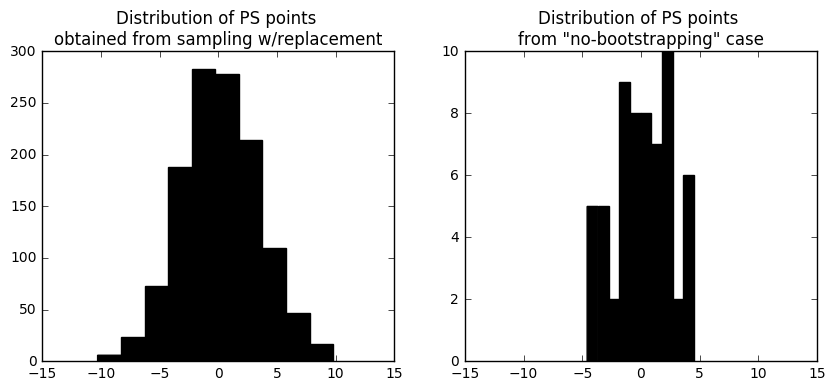

Standard deviation of PS points = 2.34626973469
Average errors = 2.27938990678
Ratio = 0.971495251835


In [128]:
import numpy as n
import pylab as p

# Bootstrapping over BL cross-multiplications instead of BLs prior to cross-multiplication

n.random.seed(7) # for reproducibility

times = 100 # length of data
nbls = 10 # number of baselines
scale = 13 # std of noise
nboots = 20 # number of bootstraps
nks = 62 # number of k's (or "simulations")

def cross_multiply(data,bls,sample=False):
    """
    Cross-multiplies unique baseline pairs.
    Averages data over time and cross-multiplications.
    Returns PS value.
    """
    crosses = []
    for bl1 in bls:
        for bl2 in bls[bl1:]:
                if bl1 != bl2:
                        cross = n.mean(data[bl1]*data[bl2]) # mean over 'time'
                        crosses.append(cross)
    if sample == True: # sample cross-multiplications w/replacement 
        samp = n.random.choice(crosses,len(crosses),replace=True)
        crosses = samp
    return n.mean(crosses) # mean over cross-multiplications

#---------------------------------------------

pts = [] # will contain PS points (size: nks)
errs = [] # will contain PS errors (size: nks)
pts_samp = [] # will contain PS points used to compute errs (from sampling w/replacement) - used for plotting only

for k in range(nks): # loop over k's (or number of "simulations")
    
    # Make noise per baseline
    data = {}
    bls = n.arange(nbls)
    for bl in bls:
        data[bl] = n.random.normal(size=times,scale=scale) # random noise 
    
    # Bootstrap
    boot_data = []
    for boot in range(nboots): # loop over bootstraps
        #bls_samp = [n.random.choice(n.arange(0,len(bls))) for bl in bls] # random sample w/replacement
        PS_pt = cross_multiply(data,bls,sample=True) # compute PS value obtained from all cross-multiplications
        pts_samp.append(PS_pt)
        boot_data.append(PS_pt)
    err = n.std(boot_data) # error is std over bootstraps
    errs.append(err) # save error 
    
    # Compute PS for no-bootstrapping case
    PS_pt = cross_multiply(data,bls,sample=False) # compute PS value obtained from all cross-multiplications
    pts.append(PS_pt)
    
# Plot
p.figure(figsize=(10,4))
p.subplot(121)
p.hist(pts_samp,color='k')
p.xlim(-15,15)
p.title('Distribution of PS points \nobtained from sampling w/replacement')
p.subplot(122)
p.hist(pts,color='k')
p.xlim(-15,15)
p.title('Distribution of PS points \nfrom "no-bootstrapping" case')
p.show()

# Print some stuff
print 'Standard deviation of PS points =',n.std(pts)
print 'Average errors =',n.mean(errs)
print 'Ratio =',n.mean(errs)/n.std(pts)